# Benchmark structural regression 

In [198]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker

In [967]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"

In [868]:
### parse trace files
def parse_trace(result_dir):
    f = os.path.basename(result_dir)
    name_trace = ".command.trace"
    trace = join(result_dir, name_trace)
    df = pd.read_csv(trace, sep = "=").T
    df = df.rename(index={'nextflow.trace/v2': f})
    return(df)

def split_name(df):
    df[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val",
               "master_msa", "master_batch",
               "slave_msa", "slave_batch","tree"]] = df.name.str.split(".", expand = True)
    return(df)


### Collect all computation files across directories 
def get_computation_times(evaluation_dir, dataset, task, extralevel = False, splitname =False):
    # Extract trace files w/ corresponding alignments
    traces = pd.DataFrame()
    alignments_dir = join(evaluation_dir,task)
    for fam in listdir(alignments_dir):
        family_dir=join(alignments_dir, fam)
        
        # remove extra level if needed
        if extralevel == False:
            family_dir = alignments_dir
            
        for f in listdir(family_dir):
            result_dir = join(family_dir,f)
            if(os.path.isdir(result_dir)):
                df = parse_trace(result_dir)
                traces = traces.append(df)
                
        if extralevel == False:
            break
    # Trace files parsed
    traces = traces.reset_index(level=0)
    traces = traces.rename(columns={'index': 'name'})
    traces["benchmarking_dataset"] = dataset
    if splitname: 
        traces = split_name(traces)
    
    traces["task"] = task
    return(traces)

In [325]:
def add_families(trees_traces):
    trees_traces["family"] = trees_traces.name.str.split(".",expand=True)[0]
    trees_traces["tree_method"] = trees_traces.name.str.split(".",expand=True)[1]
    return(trees_traces)

#### Load datasets informations (Homfam + extHomfam)

In [926]:
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})
summary_homfam_exthomfam.head(2)

,family,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,benchmarking_dataset
0,rvp,combined,93681,94.288554,22,133,rvp,xlarge,0.006405,homfam
1,zf-CCHH,combined,88345,23.251265,12,35,zf-CCHH,xlarge,0.016979,homfam


# <div style="text-align: center;"> <span align="center" style="color:blue">_________TREES_________</span> </div>


In [927]:
trees_traces_homfam = get_computation_times(join(evaluation_dir, "homfam"), "homfam", "trees", extralevel=True, splitname=False)
trees_traces_homfam = add_families(trees_traces_homfam)

trees_traces_exthomfam_v35 = get_computation_times(join(evaluation_dir, "extHomfam_v35-uniprot"), "extHomfam_v35-uniprot", "trees", extralevel=True, splitname=False)
trees_traces_exthomfam_v35 = add_families(trees_traces_exthomfam_v35)

trees_traces = pd.concat([trees_traces_homfam, trees_traces_exthomfam_v35])

stat_trees = pd.merge(trees_traces, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
stat_trees.head(2)

,name,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,...,family,tree_method,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
0,il8.FAMSA-parttree,81,600,138715,30817,142,22,1024000,32768,0,...,il8,FAMSA-parttree,combined,1073,63.762349,18,82,il8,small,1.025163
1,il8.FAMSA-medoid,379,829,138725,30822,142,22,1024000,32768,0,...,il8,FAMSA-medoid,combined,1073,63.762349,18,82,il8,small,1.025163


In [930]:
# Remove outliers for visualization 
stat_trees_nooutlier = stat_trees.sort_values(by=['realtime'], ascending=False).iloc[12:]
stat_trees_nooutlier = stat_trees_nooutlier.sort_values(by=['realtime'])
outliers = stat_trees.sort_values(by=['realtime'], ascending=False).iloc[:12]
#outliers.size_group

823    xlarge
733    xlarge
732    xlarge
627    xlarge
913    xlarge
218    xlarge
921     large
353    xlarge
463      huge
888    medium
235      huge
248    xlarge
Name: size_group, dtype: object

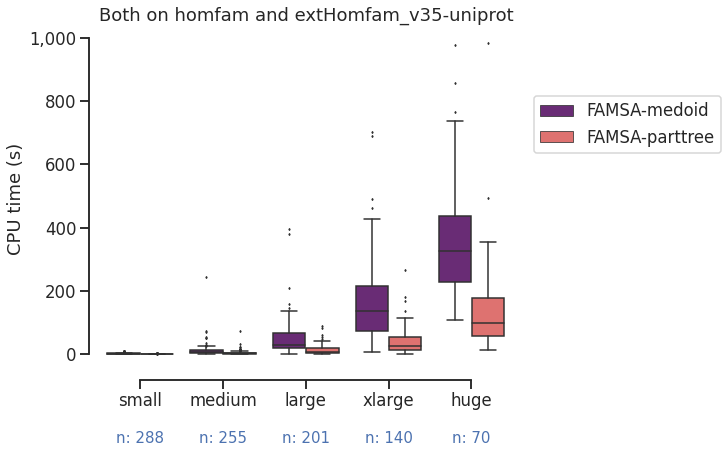

In [988]:

sns.set_theme(style="ticks")
sns.set_context("talk")

# Load the example tips dataset
f, ax = plt.subplots(figsize=(10, 7))
df = stat_trees_nooutlier
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="size_group", y="realtime",
            hue="tree_method", palette = "magma",
            data=df, linewidth=1.5, fliersize = 1.5, dodge = True)

# Calculate number of obs per group & median to position labels
nobs = df['size_group'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            -280000,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='b')
 


ax.set(ylabel='CPU time (s)', xlabel='', title = "Both on homfam and extHomfam_v35-uniprot")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)

sns.despine(offset=10, trim=True)


ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) ))
plt.subplots_adjust(right=0.70, bottom = 0.20)
plt.savefig(os.path.join(outdir, "10_treesCPU.pdf"))

In [966]:
#stat_trees[stat_trees.realtime == max(stat_trees.realtime)]

,name,realtime,%cpu,rchar,wchar,syscr,syscw,read_bytes,write_bytes,%mem,...,family,tree_method,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
823,transket_pyr.FAMSA-medoid,303846676,2,28024387,4341395,3546,22,96014824448,4341760,1,...,transket_pyr,FAMSA-medoid,combined,144526,168.60138,26,288,transket_pyr,xlarge,0.002076


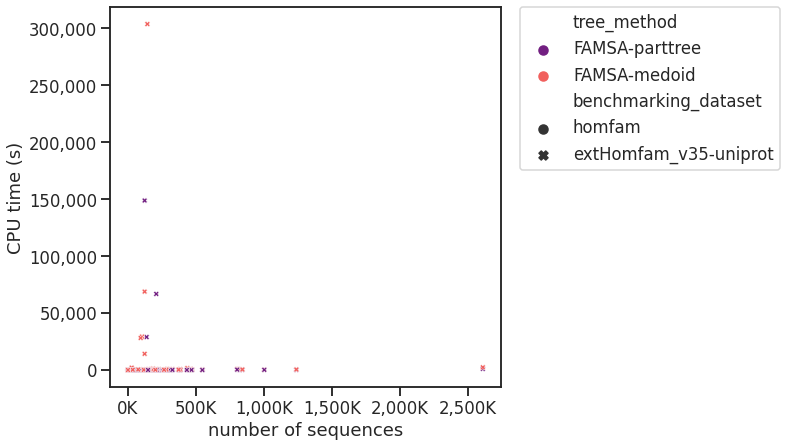

In [989]:
f, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(data=stat_trees, y="realtime", x="n_sequences", hue="tree_method",
                palette = "magma",style = "benchmarking_dataset", s = 30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(ylabel='CPU time (s)', xlabel='number of sequences')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) ))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000)+"K" ))

# <div style="text-align: center;"> <span align="center" style="color:red">_________Computation times_________</span> </div>

In [990]:
def extract_all_traces(dataset):
    # ---------- EXTRACT SEQUENCES ---------------
    traces_extracted_sequences_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "seqs_extracted")
    # ---------- AF2 PREDICTIONS -------------------------
    traces_af2_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "structures/colabfold")
    # ---------- ALIGNMENTS -------------------------
    traces_alignments_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "alignments", extralevel=True)
    # ---------- CONCATENATE AL OF THEM IN ONE ---------------
    traces = pd.concat([traces_extracted_sequences_homfam,traces_alignments_homfam], ignore_index=True)
    return(traces)

In [991]:
traces = extract_all_traces("homfam")

# <div style="text-align: center;"> <span align="center" style="color:balck">_________Load Evaluation_________</span> </div>

In [992]:
# Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
af2_grouped = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/03_summary_af2_grouped.csv")

In [993]:
def get_evaluation(evaluation_dir, dataset, splitname = True, method = "dynamic"):
    scores = evaluation_dir + "/evaluation/CSV/"+method+".scores.csv"
    scores_df = pd.read_csv(scores, sep=";", header = None).iloc[: , :-1]
    scores_df.set_axis(list(["name", "sp","tc", "column"]), axis=1, inplace=True)
    if splitname:
        if method == "dynamic": 
            scores_df[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val",
                       "master_msa", "master_batch",
                       "slave_msa", "slave_batch","tree"]] = scores_df.name.str.split(".", expand = True)
        elif method == "regressive":
            scores_df[["family", "method", "bucket_size",
                       "master_msa","tree"]] = scores_df.name.str.split(".", expand = True)            
    scores_df["benchmarking_dataset"] = dataset
    return(scores_df)

def get_evaluation_all(evaluation_dir, dataset):
    dynamic = get_evaluation(join(evaluation_dir,dataset), dataset, method = "dynamic")
    regressive = get_evaluation(join(evaluation_dir,dataset), dataset, method = "regressive")
    df = pd.concat([dynamic, regressive])
    return(df)

In [994]:
scores_df = get_evaluation_all(evaluation_dir, "homfam")

# <div style="text-align: center;"> <span align="center" style="color:lightgrey">_________MERGE_________</span> </div>

In [995]:
stats = pd.merge(scores_df, traces, on = ["name","benchmarking_dataset"])
traces.name[1]

'rnasemam.dynamic.50.dynamicX.100000.3dcoffee_msa.50.famsa_msa.100000000.FAMSA-medoid'

In [996]:
scores_df.name[2]

'TNF.regressive.50.FAMSA.FAMSA-medoid'

In [997]:
stats = pd.merge(scores_df, traces, on = ["name","benchmarking_dataset"])
stats = pd.merge(stats, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
stats.head()

,name,sp,tc,column,family,method,bucket_size,dynamicX_label,dynamicX_val,master_msa,...,inv_ctxt,task,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
0,seatoxin.dynamic.100.dynamicX.100000.3dcoffee_...,70.8,26.5,25.7,seatoxin,dynamic,100,dynamicX,100000,3dcoffee_msa,...,5,seqs_extracted,combined,93,43.634409,34,50,seatoxin,small,5.376344
1,seatoxin.dynamic.100.dynamicX.100000.3dcoffee_...,70.8,26.5,25.7,seatoxin,dynamic,100,dynamicX,100000,3dcoffee_msa,...,893,alignments,combined,93,43.634409,34,50,seatoxin,small,5.376344
2,seatoxin.regressive.50.FAMSA.FAMSA-medoid,80.3,44.9,44.7,seatoxin,regressive,50,NaN,NaN,FAMSA,...,4,alignments,combined,93,43.634409,34,50,seatoxin,small,5.376344
3,scorptoxin.regressive.50.FAMSA.FAMSA-medoid,93.1,76.7,86.3,scorptoxin,regressive,50,NaN,NaN,FAMSA,...,13,alignments,combined,363,53.256198,22,69,scorptoxin,small,2.203857
4,bowman.regressive.50.FAMSA.FAMSA-medoid,65.1,24.3,19.2,bowman,regressive,50,NaN,NaN,FAMSA,...,31,alignments,combined,499,26.144289,14,71,bowman,small,1.002004


# <div style="text-align: center;"> <span align="center" style="color:blue">_________VISUALIZE_________</span> </div>

In [923]:
# --------------   TODO -----------------
# 1 - Does the dynamic improve accuracy ? 
# a. plot all 3 metrics (SUM etc) vs the number of sequences (Dynamic + Regressive on FAMSA)
# 2 - At which computational loss? 
# b. plot all 3 metrics (SUM etc) vs the CPU time (aligner only) (Dynamic + Regressive on FAMSA)
# c. plot all 3 metrics (SUM etc) vs the CPU time (aligner only AND aligner + extract + prediction) (Dynamic + Regressive on FAMSA)
# 3 - confront gain in accuracy? Accuracy Dynamic vs Accuracy regressive
# 4 - cnfront loss in speed - cpu time dynamic vs regressive

In [998]:
# Only keep one entry (the one for the alignments) per family 
# Otherwise we would have multiple entries as we have multiple  
stats_unique = stats[stats.task == "alignments"]
stats_unique

,name,sp,tc,column,family,method,bucket_size,dynamicX_label,dynamicX_val,master_msa,...,inv_ctxt,task,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total
1,seatoxin.dynamic.100.dynamicX.100000.3dcoffee_...,70.8,26.5,25.7,seatoxin,dynamic,100,dynamicX,100000,3dcoffee_msa,...,893,alignments,combined,93,43.634409,34,50,seatoxin,small,5.376344
2,seatoxin.regressive.50.FAMSA.FAMSA-medoid,80.3,44.9,44.7,seatoxin,regressive,50,NaN,NaN,FAMSA,...,4,alignments,combined,93,43.634409,34,50,seatoxin,small,5.376344
3,scorptoxin.regressive.50.FAMSA.FAMSA-medoid,93.1,76.7,86.3,scorptoxin,regressive,50,NaN,NaN,FAMSA,...,13,alignments,combined,363,53.256198,22,69,scorptoxin,small,2.203857
4,bowman.regressive.50.FAMSA.FAMSA-medoid,65.1,24.3,19.2,bowman,regressive,50,NaN,NaN,FAMSA,...,31,alignments,combined,499,26.144289,14,71,bowman,small,1.002004
5,TNF.regressive.50.FAMSA.FAMSA-medoid,83.9,61.8,67.0,TNF,regressive,50,NaN,NaN,FAMSA,...,48,alignments,combined,556,119.902878,33,163,TNF,small,0.899281
6,ghf11.regressive.50.FAMSA.FAMSA-medoid,71.2,50.5,50.3,ghf11,regressive,50,NaN,NaN,FAMSA,...,58,alignments,combined,521,167.758157,26,227,ghf11,small,0.959693
7,hip.regressive.50.FAMSA.FAMSA-medoid,86.3,64.3,72.8,hip,regressive,50,NaN,NaN,FAMSA,...,12,alignments,combined,167,66.209581,54,85,hip,small,2.994012
8,toxin.regressive.50.FAMSA.FAMSA-medoid,73.7,28.6,28.8,toxin,regressive,50,NaN,NaN,FAMSA,...,12,alignments,combined,508,62.311024,30,77,toxin,small,3.937008
9,rnasemam.regressive.50.FAMSA.FAMSA-medoid,87.1,59.0,65.7,rnasemam,regressive,50,NaN,NaN,FAMSA,...,33,alignments,combined,498,120.072289,62,140,rnasemam,small,1.204819
10,cyt3.regressive.50.FAMSA.FAMSA-medoid,61.8,14.4,16.2,cyt3,regressive,50,NaN,NaN,FAMSA,...,16,alignments,combined,385,92.306494,52,127,cyt3,small,1.558442


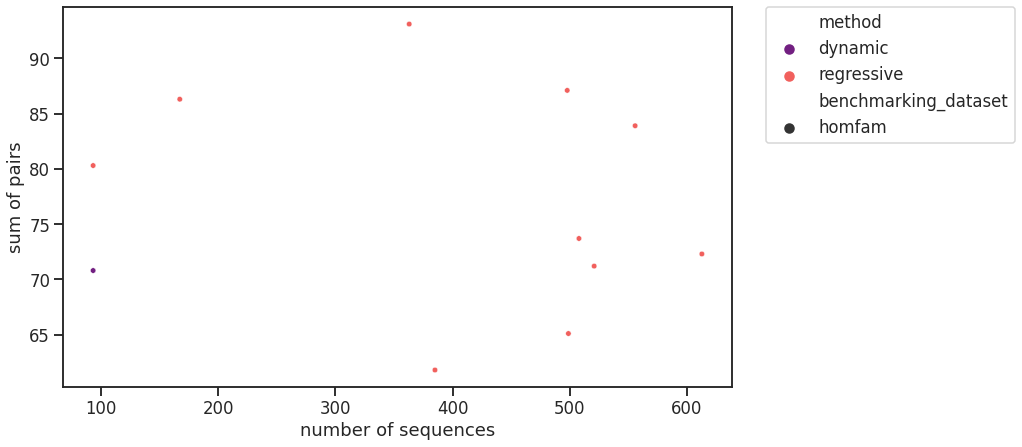

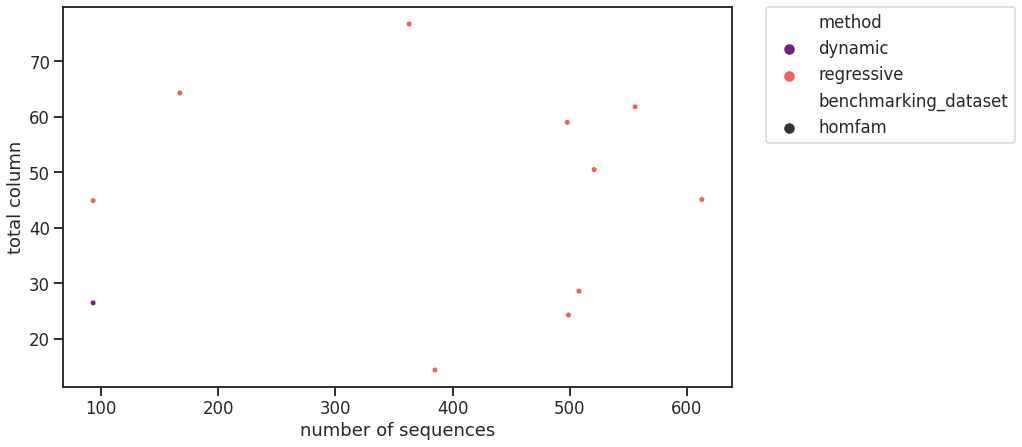

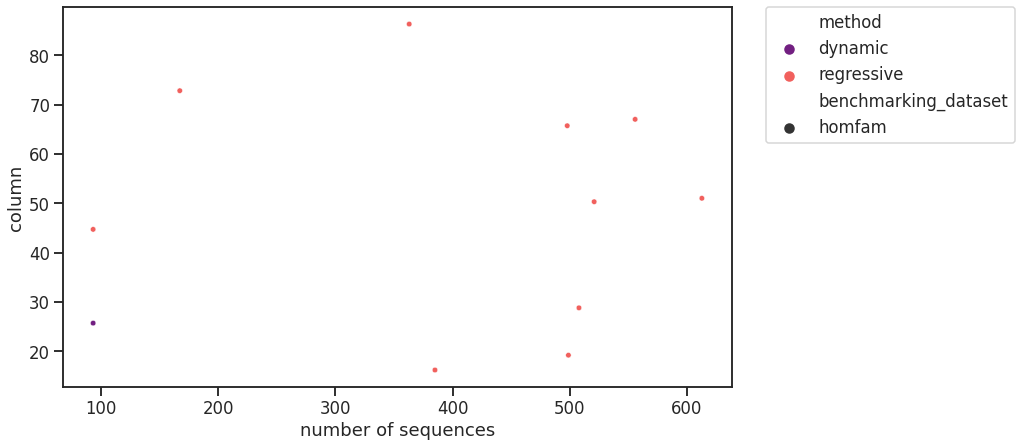

In [999]:
# 1 - Does the dynamic improve accuracy ? 
# a. plot all 3 metrics (SUM etc) vs the number of sequences (Dynamic + Regressive on FAMSA)
sns.set_context("talk")
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]

for metric in metrics:
    f, ax = plt.subplots(figsize=(12, 7))
    sns.scatterplot(data=stats_unique, y=metric[0], x="n_sequences", hue="method",
                    palette = "magma",style = "benchmarking_dataset", s = 30)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=metric[1], xlabel='number of sequences')

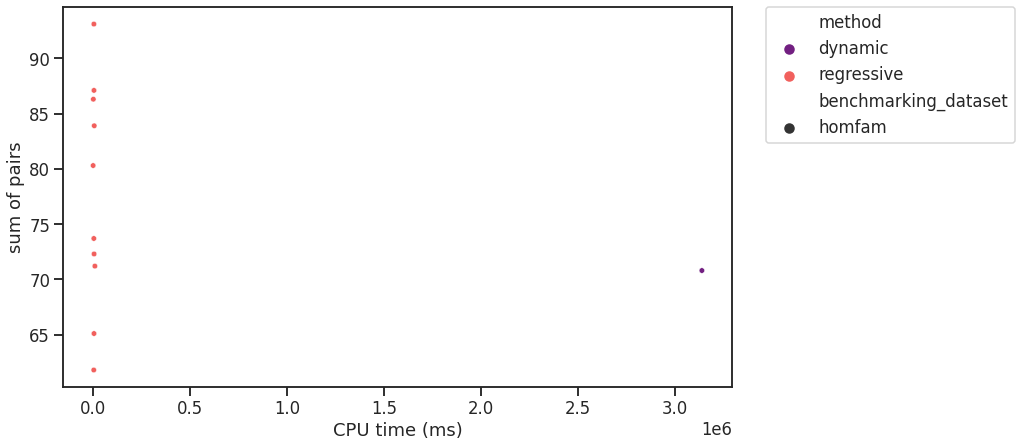

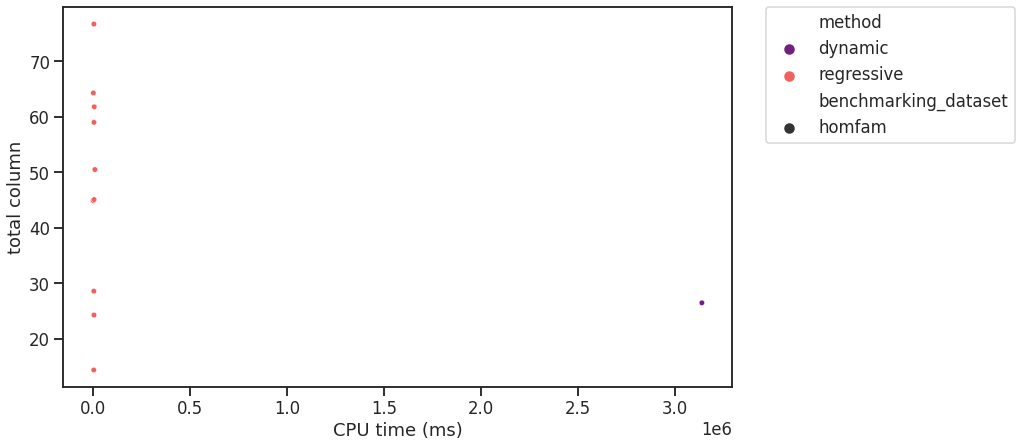

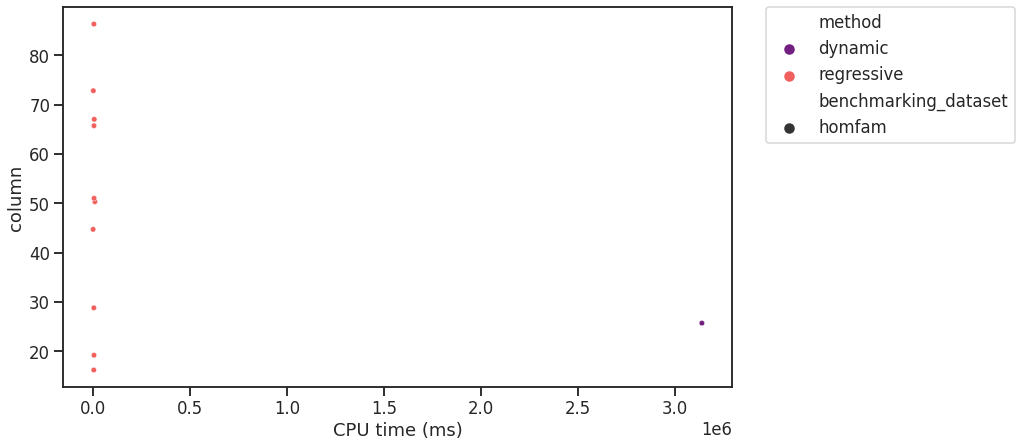

In [1000]:
# 2 - At which computational loss? 
# b. plot all 3 metrics (SUM etc) vs the CPU time (aligner only) (Dynamic + Regressive on FAMSA)
for metric in metrics:
    f, ax = plt.subplots(figsize=(12, 7))
    sns.scatterplot(data=stats_unique, y=metric[0], x="realtime", hue="method",
                    palette = "magma",style = "benchmarking_dataset", s = 30)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=metric[1], xlabel='CPU time (ms)')

In [ ]:
# c. plot all 3 metrics (SUM etc) vs the CPU time (aligner only AND aligner + extract + prediction) (Dynamic + Regressive on FAMSA)
